### Final Project motor task classification using EEG Data

#### Importing necessary libraries

In [ ]:
import numpy as np
import os
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
cd /content/gdrive/Shareddrives/C247

/content/gdrive/Shareddrives/C247


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten,Dropout
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Reshape
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras import activations

import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from load_data import *
from sklearn.model_selection import KFold
from helpers import *

%load_ext autoreload
%autoreload 2

In [ ]:
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
# Loading full data
data_path = './project'

X_train_valid, y_train_valid, X_test, y_test, person_train_valid, person_test = load_full_data(data_path)

print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115,)
Person test shape: (443,)


In [ ]:
## Adjusting the labels to {0,1,2,3}

# left hand - 0
# right hand - 1
# feet motion - 2
# tongue motion - 3

# labels are given as {769, 770, 771, 772}
base = y_train_valid.min()
y_train_valid-= base
y_test-= base

In [ ]:
# Getting data for individual subjects

subject_data_train = split_data_by_subject(X_train_valid, y_train_valid, person_train_valid)
subject_data_test = split_data_by_subject(X_test, y_test, person_test)

In [ ]:
# Changing of data dimensions

print ('Shape of training set: {}'.format(X_train_valid.shape))
print ('Shape of test set: {}'.format(X_test.shape))
print ('Shape of train labels: {}'.format(y_train_valid.shape))
print ('Shape of test labels: {}'.format(y_test.shape))

y_train_cv = to_categorical(y_train_valid, 4)
y_test_cv = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:', y_train_cv.shape)
print('Shape of test labels after categorical conversion:', y_test_cv.shape)

# Adding width of the segment to be 1
x_train_cv = X_train_valid.reshape(X_train_valid.shape[0], X_train_valid.shape[1], X_train_valid.shape[2], 1)
x_test_cv = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
print('Shape of training set after adding width info:',x_train_cv.shape)
print('Shape of test set after adding width info:',x_test_cv.shape)


# Reshaping the training and validation dataset
x_train_cv = np.swapaxes(x_train_cv, 1,3)
x_train_cv = np.swapaxes(x_train_cv, 1,2)

x_test_cv = np.swapaxes(x_test_cv, 1,3)
x_test_cv = np.swapaxes(x_test_cv, 1,2)
print('Shape of training set after dimension reshaping:',x_train_cv.shape)

print('Shape of test set after dimension reshaping:',x_test_cv.shape)

Shape of training set: (2115, 22, 1000)
Shape of test set: (443, 22, 1000)
Shape of train labels: (2115,)
Shape of test labels: (443,)
Shape of training labels after categorical conversion: (2115, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (2115, 22, 1000, 1)
Shape of test set after adding width info: (443, 22, 1000, 1)
Shape of training set after dimension reshaping: (2115, 1000, 1, 22)
Shape of test set after dimension reshaping: (443, 1000, 1, 22)


In [ ]:
train_X, val_X, train_y, val_y = train_test_split(x_train_cv, y_train_cv, test_size=0.2, random_state=42)

K fold cross validation seems to be quite an overhead on computation. Therefore using dedicated validation, train and test set. 

In [ ]:
# Splitting validation and training set into 80 - 20 ratio.

X_train, X_val, y_train, y_val = train_test_split(x_train_cv, y_train_cv, test_size=0.2, random_state=42)

### Building a 1D CNN

- Using preprocessing of data

In [ ]:
def data_prep(X,y,window_size,sub_sample,average,noise):
    # N,H,W,C ----- N,1000,1,22
    total_X = None
    total_y = None
    X = X[:,0:window_size,:,:]
    Xi = X
    X = np.transpose(X, (0,2, 3, 1))
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], X.shape[2],-1, sub_sample), axis=4)   # N,W,C,H/sub_sample
    
    X_max = np.transpose(X_max, (0,3,1, 2))
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape,y.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], X.shape[2],-1, sub_sample), axis=4)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    X_average = np.transpose(X_average, (0,3,1, 2))

    total_X = np.vstack((total_X, X_average))
    total_y = np.vstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape,y.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = Xi[:,i::sub_sample, :, :] + \
                            (np.random.normal(0.0, 0.5, Xi[:,i::sub_sample, :, :].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.vstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape,y.shape)
    return total_X,total_y



In [ ]:
window_size = 500
print(X_train.shape,y_train.shape)
X_train_dp,y_train_dp = data_prep(X_train,y_train,window_size,2,2,True)
print(X_train_dp.shape,y_train_dp.shape)

(1692, 1000, 1, 22) (1692, 4)
Shape of X after trimming: (1692, 1, 22, 500)
Shape of X after maxpooling: (1692, 250, 1, 22) (1692, 4)
Shape of X after averaging+noise and concatenating: (3384, 250, 1, 22) (1692, 4)
Shape of X after subsampling and concatenating: (6768, 250, 1, 22) (1692, 4)
(6768, 250, 1, 22) (6768, 4)


In [ ]:
window_size = 500
print(X_val.shape,y_val.shape)
X_val_dp,y_val_dp = data_prep(X_val,y_val,window_size,2,2,True)
print(X_val_dp.shape,y_val_dp.shape)

(423, 1000, 1, 22) (423, 4)
Shape of X after trimming: (423, 1, 22, 500)
Shape of X after maxpooling: (423, 250, 1, 22) (423, 4)
Shape of X after averaging+noise and concatenating: (846, 250, 1, 22) (423, 4)
Shape of X after subsampling and concatenating: (1692, 250, 1, 22) (423, 4)
(1692, 250, 1, 22) (1692, 4)


In [ ]:
window_size = 500
print(x_test_cv.shape,y_test_cv.shape)
x_test_dp,y_test_dp = data_prep(x_test_cv,y_test_cv,window_size,2,2,True)
print(x_test_dp.shape,y_test_dp.shape)

(443, 1000, 1, 22) (443, 4)
Shape of X after trimming: (443, 1, 22, 500)
Shape of X after maxpooling: (443, 250, 1, 22) (443, 4)
Shape of X after averaging+noise and concatenating: (886, 250, 1, 22) (443, 4)
Shape of X after subsampling and concatenating: (1772, 250, 1, 22) (443, 4)
(1772, 250, 1, 22) (1772, 4)


In [ ]:
# Building the CNN model using sequential class
tf.keras.backend.clear_session()
basic_cnn_model = Sequential()

# Conv. block 1
basic_cnn_model.add(Conv2D(filters=32, kernel_size=(10,1), padding='same', activation='elu', input_shape=(250,1,22)))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same')) # Read the keras documentation
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 2
basic_cnn_model.add(Conv2D(filters=64, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 3
basic_cnn_model.add(Conv2D(filters=128, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Conv. block 4
basic_cnn_model.add(Conv2D(filters=256, kernel_size=(10,1), padding='same', activation='elu'))
basic_cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
basic_cnn_model.add(BatchNormalization())
basic_cnn_model.add(Dropout(0.5))

# Output layer with Softmax activation
basic_cnn_model.add(Flatten()) # Flattens the input
basic_cnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation


# Printing the model summary
basic_cnn_model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 250, 1, 32)        7072      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 84, 1, 32)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 84, 1, 32)        128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 84, 1, 32)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 84, 1, 64)         20544     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 1, 64)        0

In [ ]:
# Model parameters
learning_rate = 1e-5
epochs = 50
cnn_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [ ]:
# Compiling the model
basic_cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
basic_cnn_model_results = basic_cnn_model.fit(X_train_dp,
             y_train_dp,
             batch_size=64,
             epochs=epochs,
             validation_data=(X_val_dp, y_val_dp), verbose=True)



Epoch 1/50
106/106 [==============================] - 3s 18ms/step - loss: 0.3620 - accuracy: 0.8651 - val_loss: 0.8524 - val_accuracy: 0.6779
Epoch 2/50
106/106 [==============================] - 1s 14ms/step - loss: 0.3565 - accuracy: 0.8650 - val_loss: 0.8573 - val_accuracy: 0.6738
Epoch 3/50
106/106 [==============================] - 1s 13ms/step - loss: 0.3648 - accuracy: 0.8559 - val_loss: 0.8500 - val_accuracy: 0.6732
Epoch 4/50
106/106 [==============================] - 1s 13ms/step - loss: 0.3698 - accuracy: 0.8574 - val_loss: 0.8517 - val_accuracy: 0.6761
Epoch 5/50
106/106 [==============================] - 2s 17ms/step - loss: 0.3668 - accuracy: 0.8620 - val_loss: 0.8586 - val_accuracy: 0.6702
Epoch 6/50
106/106 [==============================] - 1s 13ms/step - loss: 0.3474 - accuracy: 0.8691 - val_loss: 0.8596 - val_accuracy: 0.6726
Epoch 7/50
106/106 [==============================] - 1s 13ms/step - loss: 0.3672 - accuracy: 0.8611 - val_loss: 0.8521 - val_accuracy: 0.6738

In [ ]:
## Testing the basic CNN model

cnn_score = basic_cnn_model.evaluate(x_test_dp, y_test_dp, verbose=0)
print('Test accuracy of the basic CNN model:',cnn_score[1])

Test accuracy of the basic CNN model: 0.6822798848152161


In [ ]:
tf.keras.backend.clear_session()

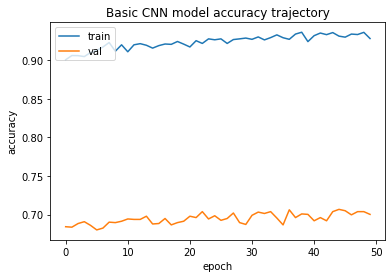

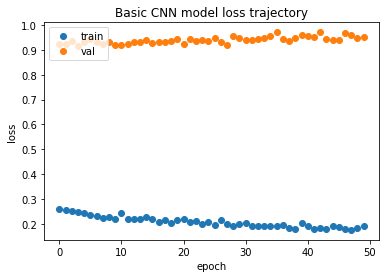

In [ ]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(basic_cnn_model_results.history['accuracy'])
plt.plot(basic_cnn_model_results.history['val_accuracy'])
plt.title('Basic CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(basic_cnn_model_results.history['loss'],'o')
plt.plot(basic_cnn_model_results.history['val_loss'],'o')
plt.title('Basic CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()